# XGBoost

In this notebook, we train XGBoost Models to predict whether a given HJ Andrews Site will be dry (0) or wet (1) 7 days into the future.

We experiment with the following train-test-splitting strategies:
- Random
- Temporal
- Site-based

At the bottom of the notebook, we provide a function for practictioners to run inference with our trained models for an inputted site-date combination.

## Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(42)

## Data Preprocessing

In [2]:
# Data Paths
DRIVERS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/drivers_xgb.csv"
OBS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/obs.parquet"
STATIC_PATH = "/Users/michaelmurphy/Desktop/usgs_data/static_vars.parquet"
DEGREES_PATH = "/Users/michaelmurphy/Desktop/usgs_data/degrees.parquet"

# Load drivers dataset as CSV
drivers = pd.read_csv(DRIVERS_PATH)

# Loads obs data
data = pd.read_parquet(OBS_PATH)

# Load in remaining datasets
static_df = pd.read_parquet(STATIC_PATH)
degrees = pd.read_parquet(DEGREES_PATH)

data

,NHDPlusID,SiteIDCode,Date,variable,value
0,55000900130309,GSWS01,1980-01-01,Discharge_CMS,0.045505
1,55000900130309,GSWS01,1980-01-02,Discharge_CMS,0.043410
2,55000900130309,GSWS01,1980-01-03,Discharge_CMS,0.048592
3,55000900130309,GSWS01,1980-01-04,Discharge_CMS,0.061872
4,55000900130309,GSWS01,1980-01-05,Discharge_CMS,0.276599
...,...,...,...,...,...
160731,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Threshold,0.000000
160732,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Censor,1.000000
160733,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_cm,51.816000
160734,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_Threshold,0.000000


In [3]:
# Loads obs data
data = pd.read_parquet(OBS_PATH)
data

,NHDPlusID,SiteIDCode,Date,variable,value
0,55000900130309,GSWS01,1980-01-01,Discharge_CMS,0.045505
1,55000900130309,GSWS01,1980-01-02,Discharge_CMS,0.043410
2,55000900130309,GSWS01,1980-01-03,Discharge_CMS,0.048592
3,55000900130309,GSWS01,1980-01-04,Discharge_CMS,0.061872
4,55000900130309,GSWS01,1980-01-05,Discharge_CMS,0.276599
...,...,...,...,...,...
160731,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Threshold,0.000000
160732,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Censor,1.000000
160733,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_cm,51.816000
160734,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_Threshold,0.000000


In [4]:
# Isolate the target variable by creating dictionary of all metrics and choosing 'value'
dfs = {val: data[data['variable'] == val ]for val in data['variable'].unique()}

wet_dry_df = dfs['HoboWetDry0.05']

In [5]:
# Make sure all NHD IDs are strings, normalize before merging
wet_dry_df['NHDPlusID'] = wet_dry_df['NHDPlusID'].astype(str)
drivers['NHDPlusID'] = drivers['NHDPlusID'].astype(str)
static_df['NHDPlusID'] = static_df['NHDPlusID'].astype(str)

# Make sure all date values are in datetime format, normalize before merging
wet_dry_df['Date'] = pd.to_datetime(wet_dry_df['Date'])
drivers['Date'] = pd.to_datetime(drivers['Date'])

static_df_pivot = static_df.pivot(
    index='NHDPlusID',
    columns='variable',
    values='value'
).reset_index()

# Merge all datasets to create one central dataset
central_df = wet_dry_df.merge(drivers, on=['NHDPlusID', 'Date'], how='inner')
central_df = central_df.merge(static_df_pivot, on='NHDPlusID', how='left')
central_df = central_df.merge(degrees, on='NHDPlusID', how='left')

/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_12076/2394861375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_dry_df['NHDPlusID'] = wet_dry_df['NHDPlusID'].astype(str)
/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_12076/2394861375.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_dry_df['Date'] = pd.to_datetime(wet_dry_df['Date'])


In [6]:
# Sort by date within each NHDPlusID
central_df = central_df.sort_values(['NHDPlusID', 'Date'])

# Introduce lag by shifting the label back 7 time steps
central_df['wet_dry_next'] = central_df.groupby('NHDPlusID')['value'].shift(-7)

# Drop all null values
central_df = central_df.dropna(subset = 'wet_dry_next')

In [7]:
central_df

,NHDPlusID,SiteIDCode,Date,variable,value,etalfalfa,etgrass,prcp,rhmax,rhmin,...,curv_median,elev_max_cm,elev_mean_cm,elev_median_cm,elev_min_cm,slp_mean_pct,slp_median_pct,In-degree,Out-degree,wet_dry_next
5,55000900029021,HoboSite89,2020-06-18,HoboWetDry0.05,1.0,7.000000,5.600000,0.000000,100.000000,34.200001,...,30.785751,111282.0,99949.028293,99436.0,88848.0,33.361886,30.785751,2,1,1.0
1951,55000900029021,HoboSite89,2020-06-19,HoboWetDry0.05,1.0,7.000000,5.700000,0.000000,87.099998,32.000000,...,30.785751,111282.0,99949.028293,99436.0,88848.0,33.361886,30.785751,2,1,1.0
1952,55000900029021,HoboSite89,2020-06-20,HoboWetDry0.05,1.0,4.700000,4.000000,1.400000,90.400002,62.600002,...,30.785751,111282.0,99949.028293,99436.0,88848.0,33.361886,30.785751,2,1,1.0
1953,55000900029021,HoboSite89,2020-06-21,HoboWetDry0.05,1.0,5.200000,4.600000,0.000000,98.400002,48.600002,...,30.785751,111282.0,99949.028293,99436.0,88848.0,33.361886,30.785751,2,1,1.0
1954,55000900029021,HoboSite89,2020-06-22,HoboWetDry0.05,1.0,8.500000,6.500000,0.000000,100.000000,29.300001,...,30.785751,111282.0,99949.028293,99436.0,88848.0,33.361886,30.785751,2,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,55000900272714,HoboSite115,2020-10-10,HoboWetDry0.05,1.0,0.536019,0.568010,50.988397,100.000000,78.420630,...,46.400970,148817.0,113542.048173,114088.0,91145.0,46.146702,46.400970,2,1,1.0
1577,55000900272714,HoboSite115,2020-10-11,HoboWetDry0.05,1.0,1.004029,0.736019,33.196215,100.000000,75.996456,...,46.400970,148817.0,113542.048173,114088.0,91145.0,46.146702,46.400970,2,1,1.0
1578,55000900272714,HoboSite115,2020-10-12,HoboWetDry0.05,1.0,0.768010,0.768010,7.936019,100.000000,83.432237,...,46.400970,148817.0,113542.048173,114088.0,91145.0,46.146702,46.400970,2,1,1.0
1579,55000900272714,HoboSite115,2020-10-13,HoboWetDry0.05,1.0,0.500000,0.500000,32.960196,100.000000,82.344320,...,46.400970,148817.0,113542.048173,114088.0,91145.0,46.146702,46.400970,2,1,1.0


## Random Split

In [8]:
def random_split(central_df):
    # Features and target
    X = central_df.drop('wet_dry_next', axis=1)
    y = central_df['wet_dry_next']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    return X_train, X_test, y_train, y_test

## Temporal Split

In [9]:
def temporal_split(central_df, split_date = '2020-9-15'):
    # Sort by time
    df = central_df.sort_values(['Date'])

    # Introduce temporal splitting
    # Every entry before 9/15 is training; rest is testing
    train = df[df['Date'] < split_date]
    test = df[df['Date'] >= split_date]

    X_train = train.drop('wet_dry_next', axis=1)
    y_train = train['wet_dry_next']
    X_test = test.drop('wet_dry_next', axis=1)
    y_test = test['wet_dry_next']

    return X_train, X_test, y_train, y_test

## Site-Based Split

In [10]:
def site_split(central_df):
    # Sort data chronologically
    central_df = central_df.sort_values(['Date']).reset_index(drop=True)

    # Split sites into train and test groups
    sites = central_df['SiteIDCode'].unique()
    train_sites = sites[:int(0.8 * len(sites))]
    test_sites  = sites[int(0.8 * len(sites)):]

    # Create site-based train and test sets
    train = central_df[central_df['SiteIDCode'].isin(train_sites)].copy()
    test  = central_df[central_df['SiteIDCode'].isin(test_sites)].copy()

    # Features and target
    X_train = train.drop('wet_dry_next', axis=1)
    y_train = train['wet_dry_next']
    X_test = test.drop('wet_dry_next', axis=1)
    y_test = test['wet_dry_next']

    return X_train, X_test, y_train, y_test

## SMOTE Resampling and Model Training

In [11]:
X_train, X_test, y_train, y_test = temporal_split(central_df)

# Drop non-numerical, non-influential columns
X_train = X_train.drop(['variable', 'NHDPlusID', 'SiteIDCode', 'Date'], axis = 1)
X_test = X_test.drop(['variable', 'NHDPlusID', 'SiteIDCode', 'Date'], axis = 1)

In [12]:
# Apply SMOTE to fix class imbalance
sm = SMOTE(random_state=42, k_neighbors=5)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [13]:
# Define XGBoost model and fit it on training data
XGB_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

XGB_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

## Metrics and Feature Importance - Temporal Split

In [14]:
# Apply model onto test data and save predictions
y_pred = XGB_model.predict(X_test)

# Obtain performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9520
ROC-AUC: 0.9560
F1 Score: 0.9693


In [15]:
# Print classification report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.827     0.963     0.890       134
         1.0      0.990     0.949     0.969       532

    accuracy                          0.952       666
   macro avg      0.909     0.956     0.929       666
weighted avg      0.957     0.952     0.953       666



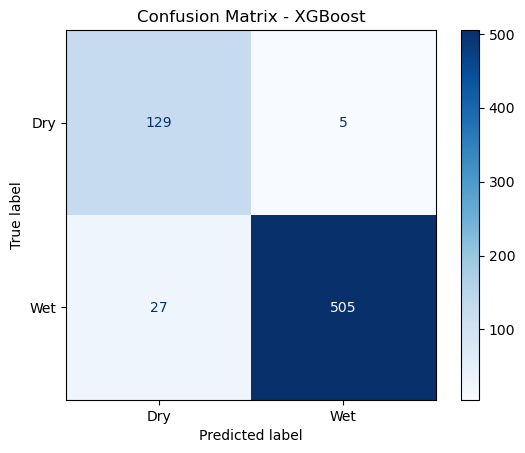

In [16]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dry', 'Wet'])
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix - XGBoost")
plt.show()

In [17]:
# Make feature importances table
feature_cols = X_train.columns.tolist()

coefficients = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": XGB_model.feature_importances_
})

#Sort by absolute value to see most important features
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print(coefficients[['Feature', 'Coefficient']].to_string(index=False))


       Feature  Coefficient
         value     0.612477
    Out-degree     0.108178
  elev_mean_cm     0.106917
   elev_max_cm     0.036471
   elev_min_cm     0.030067
 aspect_ne_pct     0.017370
 aspect_se_pct     0.012443
 aspect_sw_pct     0.008043
          srad     0.007603
      LengthKM     0.007556
         rhmin     0.007252
          tmin     0.005837
            ws     0.005656
         rhmax     0.004985
 aspect_nw_pct     0.004928
     etalfalfa     0.004864
          tmax     0.004347
            vp     0.004084
    ArbolateSu     0.003701
       etgrass     0.003669
     TotDASqKm     0.001969
           sph     0.001583
  slp_mean_pct     0.000000
     In-degree     0.000000
elev_median_cm     0.000000
slp_median_pct     0.000000
        ToNode     0.000000
   curv_median     0.000000
     curv_mean     0.000000
          prcp     0.000000
      FromNode     0.000000
      AreaSqKm     0.000000
         Slope     0.000000


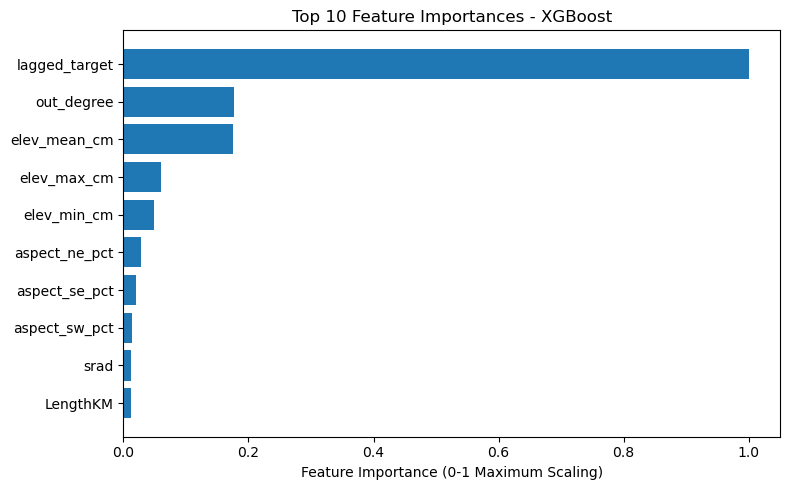

In [18]:
# Rename features for visualization
importance = coefficients[['Feature', 'Abs_Coefficient']].copy()
importance['Feature'] = importance['Feature'].replace({
    'Out-degree': 'out_degree',
    'value': 'lagged_target'
})

# Scale to 0-1 (max-normalization, consistent with LR notebook)
importance['Importance'] = importance['Abs_Coefficient'] / importance['Abs_Coefficient'].max()

# Plot top 10
top10 = importance.head(10)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top10['Feature'][::-1], top10['Importance'][::-1])
ax.set_xlabel('Feature Importance (0-1 Maximum Scaling)')
ax.set_title('Top 10 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()

## Comparison Across Split Strategies

In [19]:
# Train and evaluate XGBoost with each split strategy
drop_cols = ['variable', 'NHDPlusID', 'SiteIDCode', 'Date']
splits = {
    'Random': random_split(central_df),
    'Temporal': temporal_split(central_df),
    'Site-Based': site_split(central_df),
}

split_data = {}
results = []

for name, (X_tr, X_te, y_tr, y_te) in splits.items():
    X_tr = X_tr.drop(drop_cols, axis=1)
    X_te = X_te.drop(drop_cols, axis=1)

    # SMOTE
    sm = SMOTE(random_state=42, k_neighbors=5)
    X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

    # Train
    model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_tr_res, y_tr_res)

    # Predict
    y_pred = model.predict(X_te)

    split_data[name] = (y_te, y_pred)
    results.append({
        'Split': name,
        'Accuracy': accuracy_score(y_te, y_pred),
        'ROC-AUC': roc_auc_score(y_te, y_pred),
        'F1': f1_score(y_te, y_pred),
    })

# Display metrics table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

     Split  Accuracy  ROC-AUC       F1
    Random  0.986028 0.987054 0.991474
  Temporal  0.951952 0.955967 0.969290
Site-Based  0.663653 0.619458 0.747283


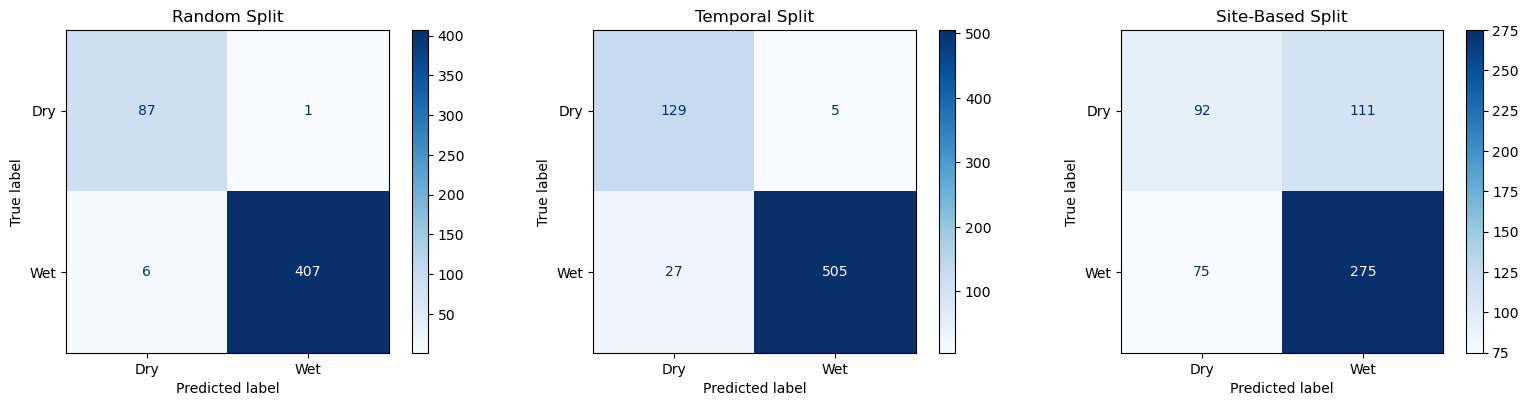


Random Split
              precision    recall  f1-score   support

         Dry      0.935     0.989     0.961        88
         Wet      0.998     0.985     0.991       413

    accuracy                          0.986       501
   macro avg      0.967     0.987     0.976       501
weighted avg      0.987     0.986     0.986       501


Temporal Split
              precision    recall  f1-score   support

         Dry      0.827     0.963     0.890       134
         Wet      0.990     0.949     0.969       532

    accuracy                          0.952       666
   macro avg      0.909     0.956     0.929       666
weighted avg      0.957     0.952     0.953       666


Site-Based Split
              precision    recall  f1-score   support

         Dry      0.551     0.453     0.497       203
         Wet      0.712     0.786     0.747       350

    accuracy                          0.664       553
   macro avg      0.632     0.619     0.622       553
weighted avg      0.653   

In [20]:
# Confusion matrices and classification reports
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, (name, (y_te, y_p)) in zip(axes, split_data.items()):
    cm = confusion_matrix(y_te, y_p, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dry', 'Wet'])
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    ax.set_title(f'{name} Split')

plt.tight_layout()
plt.show()

for name, (y_te, y_p) in split_data.items():
    print(f"\n{'='*50}")
    print(f"{name} Split")
    print('='*50)
    print(classification_report(y_te, y_p, target_names=['Dry', 'Wet'], digits=3))

## Inference

In [21]:
def predict_site_date(model, central_df, site_id, date):
  """
  Predict wet/dry status for a given site on day n+7 given its wet/dry status and features on day n.
  
  Parameters:
  -----------
  model : XGBoostClassifier
      Trained XGBoost model
  central_df : pd.DataFrame
      Complete dataset with all features
  site_id : str
      Site identifier (e.g., "HoboSite100")
  date : str
      Date in format "YYYY-MM-DD"
  
  Returns:
  --------
  str : Prediction result with probability
  """
  date = pd.to_datetime(date)
  site_id = str(site_id)

  row = central_df[(central_df["SiteIDCode"] == site_id) & (central_df["Date"] == date)]

  if row.empty:
      return f"No data found for Site {site_id} on {date.date()}"
  
  Xq = row[feature_cols]

  pred_class = model.predict(Xq)
  pred_prob = model.predict_proba(Xq)[:, 1]

  return f"Site {site_id} on {(date + pd.Timedelta(days=7)).date()} (predicted from {date.date()}): {'DRY' if pred_class == 0 else 'WET'}, (P(wet)={pred_prob[0]:.4f})"

In [22]:
# Example inference
predict_site_date(
    model=XGB_model,
    central_df=central_df,
    site_id="HoboSite100",
    date="2020-10-22"
)

'Site HoboSite100 on 2020-10-29 (predicted from 2020-10-22): DRY, (P(wet)=0.0040)'